# T-test for ChIA-PET interaction networks

In [1]:
import pandas as pd
import numpy as np
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import time

from chiapet_to_sparse import ChiaPetInteractions

We load the matrix of interactions obtained from the ChIA-PET experiment, the gene coordinates and the gene expression data.

In [2]:
bin_length = 10000000
file = 'ENCSR000BZX_HCT116_POLR2A'

file_path = '../../data/' + str(file) + '.bed'
contact_matrix = ChiaPetInteractions(file_path, bin_length, different_chrs=False)
interactions = contact_matrix.interactions
gene_meta = pd.read_csv('/home/nanni/Projects/gexi-top/data/processed/dgex_genes_with_coords.tsv', sep='\t',
                            header=0)
genexp = np.load('/home/nanni/Projects/gexi-top/data/processed/d-gex/bgedv2_GTEx_1000G_float64.npy')

Make the dataframe compatible with a bed file format and then add a new id for accessing the expression matrix.

In [3]:
gene_coordinates = gene_meta[['dgex_feature_id', 'chr', 'start', 'end', 'strand']].copy()
gene_coordinates.columns = ['dgex_feature_id', 'chrom', 'chromStart', 'chromEnd', 'strand']

gene_coordinates['strand'] = gene_coordinates['strand'].astype('object')

gene_coordinates = gene_coordinates.replace({'strand': {-1: '-', 1: '+'}}, None)

gene_coordinates['dgex_feature_filtered_id'] = np.arange(len(gene_coordinates), dtype=int)

Extend the gene coordinates to cover the promoter region

In [4]:
def extension(row, size):
    if row['strand'] == '+':
        new_value = row['chromStart'] - 1000
        if new_value < 0:
            new_value = 0
        row['chromStart'] = new_value
    elif row['strand'] == '-':
        row['chromEnd'] += 1000
    return row

gene_coord_promoter = gene_coordinates.apply(lambda row: extension(row, 1000), axis=1)

Build a matrix of gene interactions from the matrix of interacting regions (can be improved, e.g. using pybedtools)

In [5]:
def get_interacting_genes(genes, position, chromosome):
    return genes[(position > genes['chromStart']) & (position < genes['chromEnd']) 
                 & (genes['chrom'] == chromosome)]

n_genes = len(gene_coord_promoter)

gene_interactions = np.zeros((n_genes, n_genes))

for i, interaction in interactions.iterrows():
    first_genes = get_interacting_genes(gene_coord_promoter, interaction['index1'], interaction['chrom1'])
    second_genes = get_interacting_genes(gene_coord_promoter, interaction['index2'], interaction['chrom2'])
    if len(first_genes) > 0 and len(second_genes) > 0:
        for _, first_gene in first_genes.iterrows():
            for _, second_gene in second_genes.iterrows():
                if first_gene['dgex_feature_filtered_id'] != second_gene['dgex_feature_filtered_id']:
                    gene_interactions[first_gene['dgex_feature_filtered_id']][
                        second_gene['dgex_feature_filtered_id']] += 1

Select the expression values only for the genes present in the gene coordinates file

In [6]:
genexp_selected = genexp[gene_coord_promoter['dgex_feature_id']]

Compute the Pearson correlation values for the expression dataset

In [7]:
gene_correlations = np.corrcoef(genexp_selected)

Plot the correlation distributions of the interacting genes and of the randomly sampled elements.

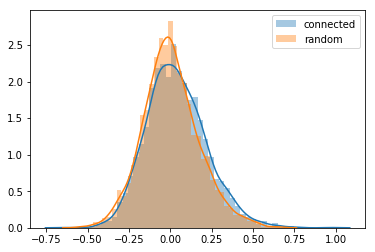

In [9]:
# Interacting distribution
interaction_idxs = np.nonzero(gene_interactions)
correlations_interacting = gene_correlations[interaction_idxs]
sns.distplot(correlations_interacting, label="connected")

# Sampled distribution
n_interacting_gene_couples = np.count_nonzero(gene_interactions)
index_x, index_y = np.where(gene_interactions == 0)
sampling_idxs = np.random.choice(np.arange(index_x.shape[0]), n_interacting_gene_couples, replace=False)

correlations_non_interacting_sampled = gene_correlations[index_x[sampling_idxs], index_y[sampling_idxs]]

sns.distplot(correlations_non_interacting_sampled, label="random")
plt.legend()
plt.show()

Perform t-test

In [10]:
ttest_ind(correlations_interacting, correlations_non_interacting_sampled, equal_var=False)

Ttest_indResult(statistic=7.599664129116409, pvalue=3.394764607185087e-14)